# Tracking Master

This notebook applies detection and tracking for all the 81 videos in the project, and saves a summary of the results.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import Tracker as t

In [3]:
if '../Detector' not in sys.path: sys.path.append('../Detector')
import DetectorNetwork as dn

In [4]:
# Configuration

META_SOURCE = r'../Photographer/videos_metadata.csv'

CROP = True
FRAME_CONSTRAINTS_LEVEL = 2
MAX_FRAMES = np.Inf

DETECTOR = '../detector/models/model_15images.mdl'

In [5]:
# Initialization

videos_dir = Path(r'D:\Media\Videos\Ayalon')

vdf = pd.read_csv(META_SOURCE, index_col=0)
videos1 = [video[:-4] for video in vdf.loc[vdf.video<'20190525_2000', 'video']]
videos2 = [video[:-4] for video in vdf.loc[np.logical_and('20190525_2000'<vdf.video,vdf.video<'20190526_1200'), 'video']]
videos3 = [video[:-4] for video in vdf.loc['20190526_1200'<vdf.video, 'video']]
len(videos1), len(videos2), len(videos3)

(17, 1, 63)

In [6]:
# MEGA RUN

cars_per_video = [[],[],[]]
for g,videos in enumerate((videos1, videos2, videos3)):
    print(f'Processing group {g+1:d}...')
    
    # set crop-area for videos group
    area = t.get_cropped_frame_area(videos[0]) if CROP else None
    
    # load model for videos group
    model = t.get_detector(area, constraints_level=FRAME_CONSTRAINTS_LEVEL)
    
    # go over videos
    for video in tqdm_notebook(videos):
        video_path = str(videos_dir/(video+'.mp4'))
        X, Y, S, N = t.process_video(model, video_path, area=area, max_frames=MAX_FRAMES, display=0, to_save=True, verbose=0)
        res = t.summarize_video(X, Y, S, video+'.mp4', area[1]-area[0], area[3]-area[2], to_save=2, verbose=False)
        assert(res[0].shape[1]==63), res[0].shape[1]
        cars_per_video[g].append(res[0].shape[0])

Processing group 1...


C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)



Processing group 2...



Processing group 3...


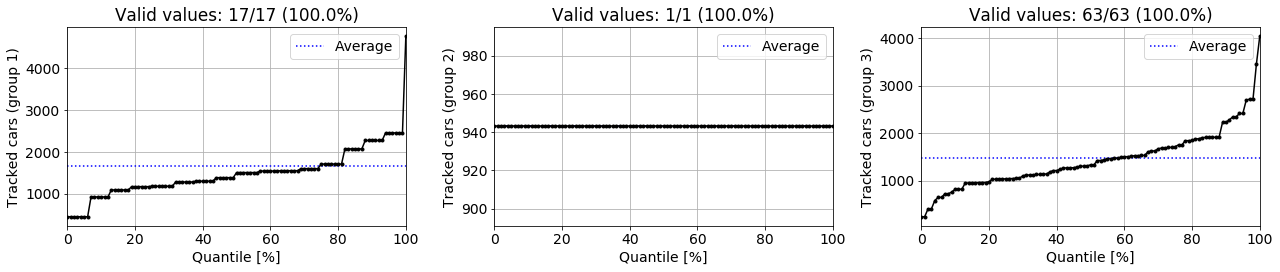

In [7]:
# Sanity check
mpl.rcParams.update({'font.size': 14})

_, axs = plt.subplots(1,3, figsize=(18,4))

for i in range(3):
    ax = axs[i]
    t.qplot(cars_per_video[i], ax=ax, ylab=f'Tracked cars (group {i+1:d})')
    
plt.tight_layout()

D:\Code\Python\Ayalon\Tracker\Tracker.py:671: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  for video in videos


(121717, 74)
long_path:	69% (19%-92%)


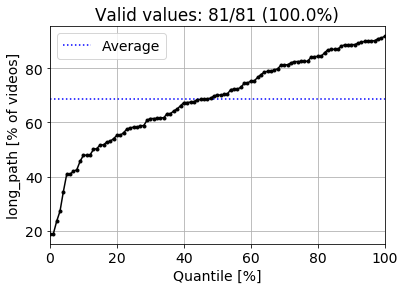

valid_x_dir:	99% (95%-100%)


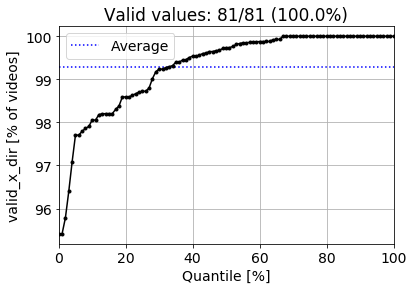

consistent_xy_nas:	100% (100%-100%)


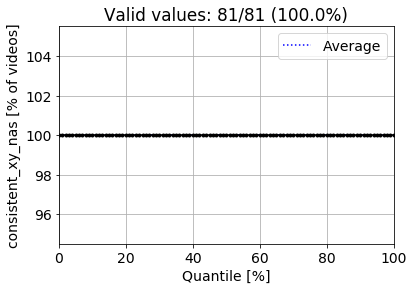

(82491, 74)


In [11]:
# Mega summary
df = t.get_merged_summaries()
print(df.shape)
df = t.filter_merged_summary(df, verbose=2)
print(df.shape)
df.to_csv(f'track_data/summary_per_car.csv', index=False)